# Shor's Algorithm: Quantum Integer Factorization

## Introduction

**Shor's algorithm** is a quantum algorithm for finding the prime factors of an integer. Discovered by Peter Shor in 1994, it was one of the first quantum algorithms to demonstrate exponential speedup over the best-known classical algorithms.

### Why Is This Important?

- **Classical difficulty**: Factoring large numbers is computationally hard. The best classical algorithms run in sub-exponential time.
- **Quantum advantage**: Shor's algorithm runs in polynomial time: $O((\log N)^3)$
- **Cryptographic implications**: RSA encryption relies on the difficulty of factoring large numbers. A large-scale quantum computer running Shor's algorithm could break RSA.

### The Core Problem

Given a composite number **N**, find its prime factors **p** and **q** such that:

$$N = p \times q$$

**Example**: Factor N = 15 → Find p = 3, q = 5

## The Algorithm Overview

Shor's algorithm converts the factoring problem into a **period-finding problem**, which quantum computers can solve efficiently using the **Quantum Fourier Transform (QFT)**.

### High-Level Steps:

1. **Choose a number** `a` coprime with N (where 1 < a < N and gcd(a, N) = 1)
2. **Quantum Period Finding**: Find the period `r` of the function:
   $$f(x) = a^x \bmod N$$
   where $a^r \equiv 1 \pmod{N}$
3. **Classical Post-Processing**: Use the period `r` to extract factors:
   - If `r` is even and $a^{r/2} \not\equiv -1 \pmod{N}$:
   - Compute: $p = \gcd(a^{r/2} - 1, N)$ and $q = \gcd(a^{r/2} + 1, N)$

### The Quantum Advantage

The quantum circuit uses **quantum parallelism** and the **Quantum Fourier Transform** to find the period exponentially faster than classical algorithms.

## Mathematical Background

### Period Finding

For a chosen `a` coprime with `N`, the function $f(x) = a^x \bmod N$ is periodic with period `r`:

$$a^r \equiv 1 \pmod{N}$$

**Example**: For N = 15, a = 7:
- $7^1 \bmod 15 = 7$
- $7^2 \bmod 15 = 4$
- $7^3 \bmod 15 = 13$
- $7^4 \bmod 15 = 1$ ← Period r = 4

### From Period to Factors

Once we find period `r`:

$$a^r \equiv 1 \pmod{N}$$
$$a^r - 1 \equiv 0 \pmod{N}$$
$$(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \pmod{N}$$

This means N divides $(a^{r/2} - 1)(a^{r/2} + 1)$, so:
- $\gcd(a^{r/2} - 1, N)$ likely contains a factor of N
- $\gcd(a^{r/2} + 1, N)$ likely contains the other factor

## Setup: Import Required Libraries

In [1]:
# Quantum computing framework
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

# Classical computation and utilities
import numpy as np
import math
from fractions import Fraction
import matplotlib.pyplot as plt

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## The Quantum Circuit Components

### 1. Modular Exponentiation: $U_a^{2^j}$ Gates

The heart of Shor's algorithm is implementing the unitary operator:

$$U_a |y\rangle = |ay \bmod N\rangle$$

We need to implement $U_a^{2^j}$ for different values of j (controlled by counting qubits).

**Key insight**: $U_a^{2^j} |y\rangle = |a^{2^j} \cdot y \bmod N\rangle$

We can compute $a^{2^j} \bmod N$ classically using modular exponentiation, then implement the resulting permutation.

In [2]:
def modular_exponentiation_gate(a, N, power, num_qubits):
    """
    Create a quantum gate implementing modular exponentiation:
    |y⟩ → |a^power * y mod N⟩ for y < N, |y⟩ → |y⟩ for y ≥ N
    
    This implements the permutation as a sequence of SWAP operations.
    
    Parameters:
        a: int - Base for modular exponentiation
        N: int - Modulus
        power: int - Exponent (typically 2^j)
        num_qubits: int - Number of qubits in register
    
    Returns:
        QuantumCircuit implementing the modular multiplication
    """
    qc = QuantumCircuit(num_qubits, name=f'U_{a}^{power}')
    
    # Compute a_power = a^power mod N classically
    a_power = pow(a, power, N)
    
    # Build the permutation mapping: y → (a_power * y) mod N
    # Only states y < N participate; y >= N are implicit identity mappings
    mapping = {}
    for y in range(N):
        mapping[y] = (a_power * y) % N
    
    # Decompose permutation into cycles
    visited = set()
    cycles = []
    
    # Only iterate over states < N; states >= N are identity
    for start in range(N):
        if start in visited or mapping[start] == start:
            continue
        
        cycle = []
        current = start
        while current not in visited:
            cycle.append(current)
            visited.add(current)
            current = mapping[current]
        
        if cycle:
            cycles.append(cycle)
    
    # Implement each cycle as a series of SWAPs
    for cycle in cycles:
        for i in range(len(cycle) - 1):
            # SWAP computational basis states cycle[i] and cycle[i+1]
            swap_circuit = create_basis_state_swap(cycle[i], cycle[i+1], num_qubits)
            qc.compose(swap_circuit, inplace=True)
    
    return qc


def create_basis_state_swap(state1, state2, num_qubits):
    """
    Create a circuit that swaps two computational basis states.
    Uses multi-controlled X gates to implement the SWAP.
    
    Parameters:
        state1, state2: int - Basis states to swap
        num_qubits: int - Number of qubits
    
    Returns:
        QuantumCircuit implementing the swap
    """
    qc = QuantumCircuit(num_qubits)
    
    # Convert states to binary
    state1_bits = format(state1, f'0{num_qubits}b')
    state2_bits = format(state2, f'0{num_qubits}b')
    
    # Find qubits that differ
    diff_qubits = [i for i in range(num_qubits) if state1_bits[i] != state2_bits[i]]
    # Find qubits that must be in specific state (controls)
    control_qubits = [(i, int(state1_bits[i])) for i in range(num_qubits) if i not in diff_qubits]
    
    # For each differing qubit, apply controlled-X with appropriate controls
    for target_qubit in diff_qubits:
        # Apply X gates to flip 0-controls to 1
        for ctrl_qubit, ctrl_val in control_qubits:
            if ctrl_val == 0:
                qc.x(ctrl_qubit)
        
        # Apply multi-controlled X
        if len(control_qubits) > 0:
            ctrl_indices = [q for q, _ in control_qubits]
            qc.mcx(ctrl_indices, target_qubit)
        else:
            qc.x(target_qubit)
        
        # Undo X gates on 0-controls
        for ctrl_qubit, ctrl_val in control_qubits:
            if ctrl_val == 0:
                qc.x(ctrl_qubit)
    
    return qc


print("✓ Modular exponentiation functions defined")

✓ Modular exponentiation functions defined


### 2. Quantum Fourier Transform (QFT)

The QFT is the quantum analogue of the discrete Fourier transform. It transforms the quantum state to reveal the period.

$$\text{QFT}|j\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi ijk/2^n}|k\rangle$$

We use the **inverse QFT** to extract the phase information from the quantum state.

In [3]:
def create_inverse_qft(num_qubits):
    """
    Create inverse Quantum Fourier Transform circuit.
    
    Parameters:
        num_qubits: int - Number of qubits
    
    Returns:
        QuantumCircuit implementing inverse QFT
    """
    qc = QuantumCircuit(num_qubits, name='IQFT')
    
    # Apply IQFT: reverse operations of QFT
    # Iterate through qubits in reverse order
    for j in range(num_qubits - 1, -1, -1):
        # Apply controlled phase rotations before Hadamard
        for k in range(j - 1, -1, -1):
            qc.cp(-np.pi / (2**(j - k)), k, j)
        # Apply Hadamard
        qc.h(j)
    
    # Swap qubits to reverse order
    for j in range(num_qubits // 2):
        qc.swap(j, num_qubits - j - 1)
    
    return qc


print("✓ Inverse QFT function defined")

✓ Inverse QFT function defined


## Building the Complete Shor's Circuit

The complete quantum circuit has two registers:

1. **Counting register** (n qubits): Initialized in superposition, measures the phase
2. **Work register** (m qubits): Holds the value being transformed, initialized to |1⟩

### Circuit Structure:

```
Counting qubits:  |0⟩─H─●────────●────────●────────[IQFT]─M
                  |0⟩─H─│─────●──│────────│────────[IQFT]─M
                  |0⟩─H─│──●──│──│────────│────────[IQFT]─M
                        │  │  │  │        │
Work register:    |1⟩───U  U² U⁴ ... U^(2^(n-1))
                  |0⟩─────────────────────────────────────
                  |0⟩─────────────────────────────────────
```

where U = modular exponentiation gate

In [4]:
def shor_circuit(a, N, num_counting_qubits, num_work_qubits):
    """
    Build the complete Shor's algorithm quantum circuit.
    
    Parameters:
        a: int - Number coprime with N
        N: int - Number to factor
        num_counting_qubits: int - Qubits for phase estimation (more = better precision)
        num_work_qubits: int - Qubits to represent values mod N (need 2^m > N)
    
    Returns:
        QuantumCircuit: Complete Shor's algorithm circuit
    """
    total_qubits = num_counting_qubits + num_work_qubits
    qc = QuantumCircuit(total_qubits, num_counting_qubits)
    
    # --- Step 1: Initialize counting qubits in superposition ---
    for q in range(num_counting_qubits):
        qc.h(q)
    qc.barrier()
    
    # --- Step 2: Initialize work register to |1⟩ ---
    # (This is the starting point for modular exponentiation)
    qc.x(num_counting_qubits)  # First qubit of work register
    qc.barrier()
    
    # --- Step 3: Apply controlled-U^(2^j) operations ---
    # Each counting qubit controls a modular exponentiation
    for j in range(num_counting_qubits):
        power = 2**j
        
        # Create the modular exponentiation gate
        u_gate = modular_exponentiation_gate(a, N, power, num_work_qubits)
        
        # Make it controlled by counting qubit j
        cu_gate = u_gate.to_gate().control(1)
        
        # Apply to: control = qubit j, targets = work register qubits
        work_qubits = list(range(num_counting_qubits, total_qubits))
        qc.append(cu_gate, [j] + work_qubits)
    
    qc.barrier()
    
    # --- Step 4: Apply inverse QFT to counting register ---
    iqft_gate = create_inverse_qft(num_counting_qubits).to_gate()
    qc.append(iqft_gate, range(num_counting_qubits))
    qc.barrier()
    
    # --- Step 5: Measure counting register ---
    qc.measure(range(num_counting_qubits), range(num_counting_qubits))
    
    return qc


print("✓ Shor's circuit function defined")

✓ Shor's circuit function defined


## Classical Post-Processing

After measuring the counting register, we need to:
1. Convert the measured bitstring to a phase estimate
2. Use continued fractions to find the period r
3. Verify r is valid (a^r ≡ 1 mod N)
4. Extract factors using gcd

In [5]:
def extract_period_from_measurement(measured_value, num_counting_qubits, a, N):
    """
    Extract period from a measurement result.
    
    Parameters:
        measured_value: int - Measured integer from counting register
        num_counting_qubits: int - Number of counting qubits
        a: int - Base of modular exponentiation
        N: int - Modulus
    
    Returns:
        tuple: (period_candidate, is_valid, phase, fraction)
    """
    # Calculate phase: φ = measured_value / 2^n
    phase = measured_value / (2**num_counting_qubits)
    
    # Use continued fractions to find best rational approximation s/r
    # where r is the period candidate
    frac = Fraction(phase).limit_denominator(N)
    period_candidate = frac.denominator
    
    # Verify if this is the actual period
    is_valid = (period_candidate > 0 and pow(a, period_candidate, N) == 1)
    
    return period_candidate, is_valid, phase, frac


def extract_factors(a, period, N):
    """
    Extract factors of N given the period of a^x mod N.
    
    Parameters:
        a: int - Base
        period: int - Period r where a^r ≡ 1 (mod N)
        N: int - Number to factor
    
    Returns:
        tuple: (factor1, factor2) if successful, None otherwise
    """
    # Period must be even
    if period % 2 != 0:
        return None
    
    # Compute x = a^(r/2) mod N
    x = pow(a, period // 2, N)
    
    # x should not be ±1 mod N
    if x == 1 or x == N - 1:
        return None
    
    # Compute gcd(x ± 1, N)
    factor1 = math.gcd(x - 1, N)
    factor2 = math.gcd(x + 1, N)
    
    # Check if we found non-trivial factors
    if 1 < factor1 < N:
        return (factor1, N // factor1)
    elif 1 < factor2 < N:
        return (factor2, N // factor2)
    
    return None


print("✓ Classical post-processing functions defined")

✓ Classical post-processing functions defined


## Complete Shor's Algorithm Implementation

Now let's put everything together into a complete implementation that:
1. Builds the quantum circuit
2. Runs it on a simulator
3. Analyzes the results
4. Extracts the factors

In [6]:
def run_shor_algorithm(a, N, num_counting_qubits=8, shots=2048, verbose=True):
    """
    Run Shor's algorithm to factor N using base a.
    
    Parameters:
        a: int - Number coprime with N (1 < a < N)
        N: int - Number to factor
        num_counting_qubits: int - Counting register size (affects precision)
        shots: int - Number of measurements
        verbose: bool - Print detailed information
    
    Returns:
        dict: Results including factors if found
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"Shor's Algorithm: Factoring N = {N} using a = {a}")
        print(f"{'='*70}\n")
    
    # --- Determine work register size ---
    num_work_qubits = math.ceil(math.log2(N)) + 1
    
    if verbose:
        print(f"Configuration:")
        print(f"  • Counting qubits: {num_counting_qubits}")
        print(f"  • Work qubits: {num_work_qubits}")
        print(f"  • Total qubits: {num_counting_qubits + num_work_qubits}")
        print(f"  • Shots: {shots}\n")
    
    # --- Build quantum circuit ---
    if verbose:
        print("Building quantum circuit...")
    
    qc = shor_circuit(a, N, num_counting_qubits, num_work_qubits)
    
    if verbose:
        print(f"  • Circuit depth: {qc.depth()}")
        print(f"  • Gate count: {qc.size()}\n")
    
    # --- Execute circuit ---
    if verbose:
        print("Executing circuit on quantum simulator...")
    
    backend = AerSimulator()
    transpiled_qc = transpile(qc, backend, optimization_level=2)
    
    if verbose:
        print(f"  • Transpiled depth: {transpiled_qc.depth()}")
    
    result = backend.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts()
    
    # --- Analyze measurement results ---
    if verbose:
        print(f"\nAnalyzing top measurement results...\n")
    
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    # Try to find period from top results
    for rank, (bitstring, count) in enumerate(sorted_counts[:10], 1):
        measured_value = int(bitstring, 2)
        
        # Skip trivial measurement |000...0⟩
        if measured_value == 0:
            continue
        
        period, is_valid, phase, frac = extract_period_from_measurement(
            measured_value, num_counting_qubits, a, N
        )
        
        if verbose:
            print(f"Rank {rank}: |{bitstring}⟩ ({count} times, {count/shots*100:.1f}%)")
            print(f"  • Measured value: {measured_value}")
            print(f"  • Phase: φ = {phase:.6f}")
            print(f"  • Continued fraction: {frac}")
            print(f"  • Period candidate: r = {period}")
            print(f"  • Valid period: {is_valid}")
        
        if not is_valid:
            if verbose:
                print(f"  ✗ Not a valid period\n")
            continue
        
        # Try to extract factors
        factors = extract_factors(a, period, N)
        
        if factors:
            if verbose:
                print(f"  ✓ SUCCESS! Found factors using period r = {period}")
                x = pow(a, period // 2, N)
                print(f"  ✓ Computed: x = {a}^{period//2} mod {N} = {x}")
                print(f"  ✓ Factors: {factors[0]} × {factors[1]} = {N}\n")
                print(f"{'='*70}")
                print(f"FACTORIZATION SUCCESSFUL!")
                print(f"{N} = {factors[0]} × {factors[1]}")
                print(f"{'='*70}")
            
            return {
                'success': True,
                'method': 'quantum',
                'factors': factors,
                'period': period,
                'a': a,
                'N': N,
                'measurement': bitstring,
                'phase': phase,
                'counts': counts
            }
        else:
            if verbose:
                print(f"  ✗ Period r = {period} didn't yield factors\n")
    
    # Failed to find factors
    if verbose:
        print(f"\n✗ Failed to find factors with a = {a}")
        print(f"   Try a different value of 'a' or increase counting qubits\n")
    
    return {
        'success': False,
        'a': a,
        'N': N,
        'counts': counts
    }


print("✓ Complete Shor's algorithm implementation ready")

✓ Complete Shor's algorithm implementation ready


## Example 1: Factor N = 15

Let's factor 15 (= 3 × 5) using Shor's algorithm.

We'll try a = 7, which is coprime with 15.


Shor's Algorithm: Factoring N = 15 using a = 7

Configuration:
  • Counting qubits: 8
  • Work qubits: 5
  • Total qubits: 13
  • Shots: 2048

Building quantum circuit...
  • Circuit depth: 12
  • Gate count: 26

Executing circuit on quantum simulator...
  • Transpiled depth: 891

Analyzing top measurement results...

Rank 1: |11111111⟩ (150 times, 7.3%)
  • Measured value: 255
  • Phase: φ = 0.996094
  • Continued fraction: 1
  • Period candidate: r = 1
  • Valid period: False
  ✗ Not a valid period

Rank 2: |01111111⟩ (134 times, 6.5%)
  • Measured value: 127
  • Phase: φ = 0.496094
  • Continued fraction: 1/2
  • Period candidate: r = 2
  • Valid period: False
  ✗ Not a valid period

Rank 3: |11111110⟩ (129 times, 6.3%)
  • Measured value: 254
  • Phase: φ = 0.992188
  • Continued fraction: 1
  • Period candidate: r = 1
  • Valid period: False
  ✗ Not a valid period

Rank 4: |01111110⟩ (92 times, 4.5%)
  • Measured value: 126
  • Phase: φ = 0.492188
  • Continued fraction: 1/2
  • 

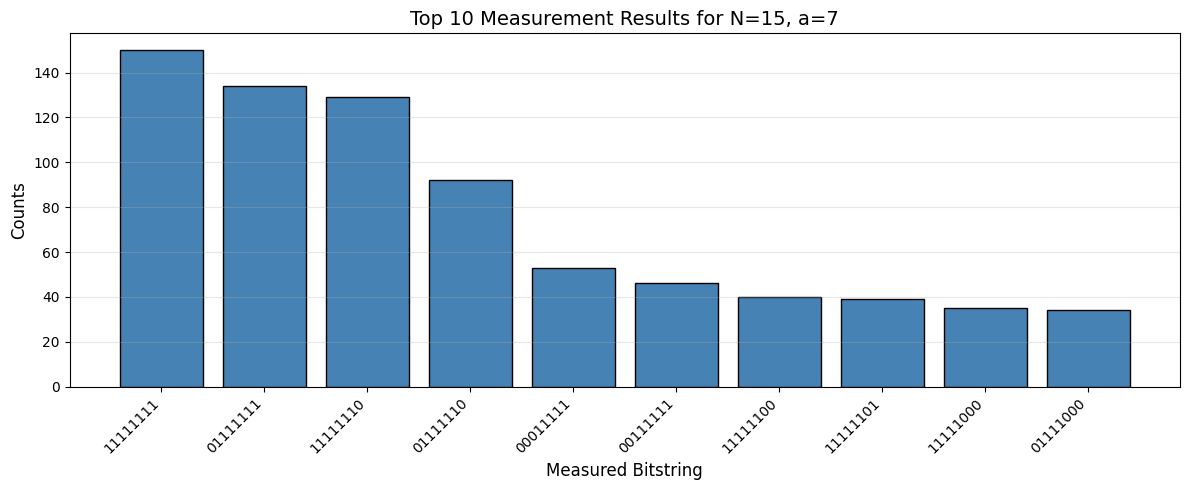

In [10]:
# Factor N = 15 using a = 7
result = run_shor_algorithm(a=7, N=15, num_counting_qubits=8, shots=2048)

# Visualize measurement results (top 10 only)
if 'counts' in result:
    # Get top 10 measurements
    sorted_counts = sorted(result['counts'].items(), key=lambda x: x[1], reverse=True)
    top_10_counts = dict(sorted_counts[:10])
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    bitstrings = list(top_10_counts.keys())
    counts = list(top_10_counts.values())
    
    ax.bar(range(len(bitstrings)), counts, color='steelblue', edgecolor='black')
    ax.set_xticks(range(len(bitstrings)))
    ax.set_xticklabels(bitstrings, rotation=45, ha='right')
    ax.set_xlabel('Measured Bitstring', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_title(f"Top 10 Measurement Results for N={result['N']}, a={result['a']}", fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### Understanding the Results

For N = 15, a = 7:
- The period is r = 4 (since $7^4 \bmod 15 = 1$)
- The quantum circuit creates peaks at phases φ = k/r = k/4
- Measuring gives us values that reveal the period
- From period r = 4:
  - $x = 7^2 \bmod 15 = 49 \bmod 15 = 4$
  - $\gcd(4-1, 15) = \gcd(3, 15) = 3$ ✓
  - $\gcd(4+1, 15) = \gcd(5, 15) = 5$ ✓
  - Factors: 3 × 5 = 15

## Example 2: Factor N = 21

Let's try a slightly larger number: 21 = 3 × 7


Shor's Algorithm: Factoring N = 21 using a = 2

Configuration:
  • Counting qubits: 8
  • Work qubits: 6
  • Total qubits: 14
  • Shots: 2048

Building quantum circuit...
  • Circuit depth: 12
  • Gate count: 26

Executing circuit on quantum simulator...
  • Circuit depth: 12
  • Gate count: 26

Executing circuit on quantum simulator...
  • Transpiled depth: 15706
  • Transpiled depth: 15706

Analyzing top measurement results...

Rank 1: |11111111⟩ (167 times, 8.2%)
  • Measured value: 255
  • Phase: φ = 0.996094
  • Continued fraction: 1
  • Period candidate: r = 1
  • Valid period: False
  ✗ Not a valid period

Rank 2: |11111110⟩ (122 times, 6.0%)
  • Measured value: 254
  • Phase: φ = 0.992188
  • Continued fraction: 1
  • Period candidate: r = 1
  • Valid period: False
  ✗ Not a valid period

Rank 3: |01111111⟩ (119 times, 5.8%)
  • Measured value: 127
  • Phase: φ = 0.496094
  • Continued fraction: 1/2
  • Period candidate: r = 2
  • Valid period: False
  ✗ Not a valid period

Ra

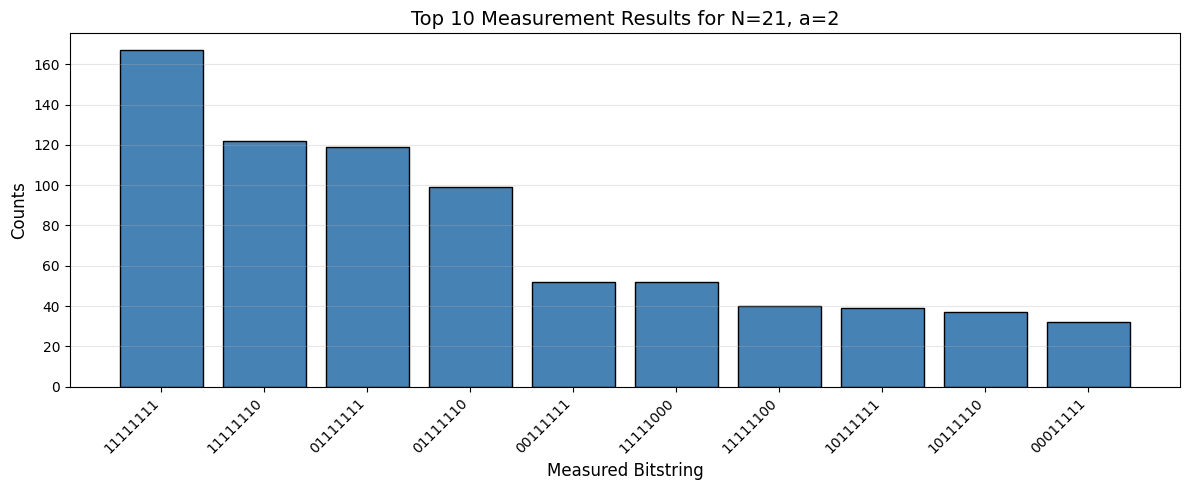

In [11]:
# Factor N = 21 using a = 2
result = run_shor_algorithm(a=2, N=21, num_counting_qubits=8, shots=2048)

# Visualize measurement results (top 10 only)
if 'counts' in result:
    # Get top 10 measurements
    sorted_counts = sorted(result['counts'].items(), key=lambda x: x[1], reverse=True)
    top_10_counts = dict(sorted_counts[:10])
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    bitstrings = list(top_10_counts.keys())
    counts = list(top_10_counts.values())
    
    ax.bar(range(len(bitstrings)), counts, color='steelblue', edgecolor='black')
    ax.set_xticks(range(len(bitstrings)))
    ax.set_xticklabels(bitstrings, rotation=45, ha='right')
    ax.set_xlabel('Measured Bitstring', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_title(f"Top 10 Measurement Results for N={result['N']}, a={result['a']}", fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Exploring Different Values of 'a'

Sometimes we need to try multiple values of `a` to successfully factor N. Let's create a function that tries multiple values.

In [12]:
def factor_with_multiple_attempts(N, max_attempts=5, num_counting_qubits=8):
    """
    Attempt to factor N by trying multiple values of a.
    
    Parameters:
        N: int - Number to factor
        max_attempts: int - Maximum values of 'a' to try
        num_counting_qubits: int - Size of counting register
    
    Returns:
        dict: Factorization results
    """
    print(f"\n{'='*70}")
    print(f"Attempting to factor N = {N}")
    print(f"Trying up to {max_attempts} different values of 'a'")
    print(f"{'='*70}\n")
    
    # Generate candidate values of a (coprime with N)
    candidates = [a for a in range(2, N) if math.gcd(a, N) == 1]
    
    # Shuffle for randomness (np.random.shuffle operates in-place on the list)
    np.random.shuffle(candidates)
    
    for i, a in enumerate(candidates[:max_attempts], 1):
        print(f"\nAttempt {i}/{max_attempts}: Trying a = {a}")
        print("-" * 70)
        
        result = run_shor_algorithm(a, N, num_counting_qubits, shots=2048, verbose=False)
        
        if result['success']:
            print(f"\n✓ SUCCESS with a = {a}!")
            print(f"✓ Factors: {result['factors'][0]} × {result['factors'][1]} = {N}")
            return result
        else:
            print(f"✗ Failed with a = {a}, trying next value...")
    
    print(f"\n✗ Failed to factor {N} after {max_attempts} attempts")
    print(f"   Consider increasing counting qubits or trying more values of 'a'")
    return {'success': False, 'N': N}


# Try to factor 35 = 5 × 7
result = factor_with_multiple_attempts(N=35, max_attempts=5, num_counting_qubits=10)


Attempting to factor N = 35
Trying up to 5 different values of 'a'


Attempt 1/5: Trying a = 19
----------------------------------------------------------------------
✗ Failed with a = 19, trying next value...

Attempt 2/5: Trying a = 24
----------------------------------------------------------------------
✗ Failed with a = 19, trying next value...

Attempt 2/5: Trying a = 24
----------------------------------------------------------------------
✗ Failed with a = 24, trying next value...

Attempt 3/5: Trying a = 9
----------------------------------------------------------------------
✗ Failed with a = 24, trying next value...

Attempt 3/5: Trying a = 9
----------------------------------------------------------------------
✗ Failed with a = 9, trying next value...

Attempt 4/5: Trying a = 27
----------------------------------------------------------------------
✗ Failed with a = 9, trying next value...

Attempt 4/5: Trying a = 27
-------------------------------------------------------

## Visualizing the Quantum Circuit

Let's visualize what the Shor circuit looks like for a small example.

Shor's Circuit for N=15, a=7
Counting qubits: 4, Work qubits: 4

Circuit structure (compressed gates):


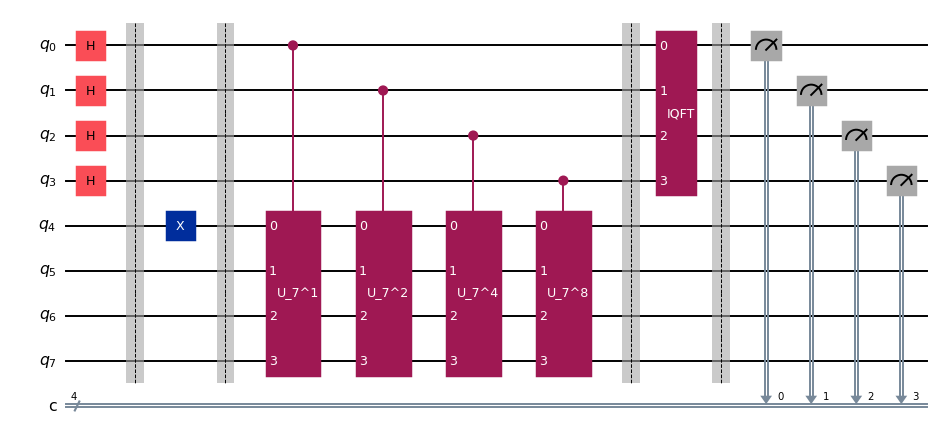

In [18]:
# Create a small circuit for visualization
a_vis = 7
N_vis = 15
counting_qubits_vis = 4  # Small for visualization
work_qubits_vis = 4

qc_vis = shor_circuit(a_vis, N_vis, counting_qubits_vis, work_qubits_vis)

print(f"Shor's Circuit for N={N_vis}, a={a_vis}")
print(f"Counting qubits: {counting_qubits_vis}, Work qubits: {work_qubits_vis}")
print(f"\nCircuit structure (compressed gates):")

# Draw the circuit - display directly without assignment
qc_vis.draw('mpl', scale=0.7, fold=-1)

## Summary and Key Takeaways

### What We Learned:

1. **Shor's Algorithm** converts factoring into period finding, which quantum computers solve efficiently

2. **Key Components**:
   - Modular exponentiation: $U_a |y\rangle = |ay \bmod N\rangle$
   - Quantum Fourier Transform: Extracts period information
   - Continued fractions: Converts phase to period
   - GCD: Extracts factors from period

3. **Quantum Advantage**:
   - Classical factoring: Sub-exponential time
   - Shor's algorithm: Polynomial time $O((\log N)^3)$

4. **Practical Considerations**:
   - More counting qubits → Better phase resolution
   - May need multiple attempts with different values of 'a'
   - Success depends on measuring a good phase estimate

### Historical Context:

- **1994**: Peter Shor discovers the algorithm
- **2001**: First experimental demonstration (factored 15)
- **Today**: Quantum computers have factored only small integers (generally below 100), still far from breaking real-world cryptography
- **Future**: Breaking RSA-2048 requires ~20 million noisy qubits or ~4000 perfect qubits

### Applications:

- **Cryptography**: Threatens RSA encryption
- **Number Theory**: Efficient primality testing
- **Chemistry**: Related algorithms for simulation
- **Optimization**: Quantum speedup principles